In [1]:
%matplotlib inline

import itertools 

import matplotlib.pyplot as plt
import numpy as np
from qiskit import Aer, BasicAer, ClassicalRegister, execute, IBMQ, QuantumCircuit, QuantumRegister 
from qiskit.circuit.library.standard_gates import U2Gate
from qiskit.providers.aer.noise import NoiseModel
from qiskit.tools.visualization import plot_histogram
from qiskit.visualization.bloch import Bloch

from scipy.optimize import minimize

# Introduction

My objective is to find the following Hamiltonian ground state. 

$$
H
=
\begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & 0 & -1  & 0 \\ 0 & -1 & 0  & 0 \\ 0 & 0 & 0 & 1 \end{bmatrix}$$

In other words, we want to figure out the eigenvector with the minimum eigenvalue. In order to solve this problem, we'll use a **variational quantum eigensolver** (VQE).  

*With a simple 4x4 matrix it is easy to find the ground state with any numerical python library (ex: numpy). However, I will use this simple matrix to learn how to implement VQE and I will use numpy in order to verify, if VQE gets to the ground state.*

## Ground state using numpy

In [2]:
hamiltonian = np.array([[1,0,0,0],
                        [0,0,-1,0],
                        [0,-1,0,0],
                        [0,0,0,1]])

In [3]:
def compute_ground_state(matrix):
    eig_values, eig_vectors = np.linalg.eig(matrix)
    return np.min(eig_values), eig_vectors[:, np.argmin(eig_values)]

ground_energy, ground_state = compute_ground_state(hamiltonian)

# Reshape is used, just to visualize the ground state as a column vector.
print(f"Minimun energy = {ground_energy} with a state = \n{ground_state.reshape(-1, 1)}")

Minimun energy = -1.0 with a state = 
[[0.        ]
 [0.70710678]
 [0.70710678]
 [0.        ]]


Notice that the state $$[0, \frac{1}{\sqrt{2}}, \frac{1}{\sqrt{2}}, 0]$$ can be rewritten in the computational basis as: $$\frac{1}{\sqrt{2}}\big[ \left|01\right\rangle + \left|10\right\rangle \big]$$

## Variational Quantum Eigensolver (VQE)


VQE is an algorithm that finds the smallest eigenvalue and the associated eigenvector from a given Hamiltonian. The idea behind this algorithm is quite simple if we understand the **variational principle**.   

The variational principle consists in choosing a state $\left| \psi \right\rangle$. Then, we can compute the expected energy of the system as:  

$$ E =\left\langle \psi \right| H \left| \psi \right\rangle$$

So, our first guess, $\left| \psi \right\rangle$, has an expected energy $E$. Now, it would be really cool if in the next step we can do a second guess $\left| \psi_{2} \right\rangle$ with and expected energy $E_{2}$ lower than $E$, so $E_{2} < E$. Indeed this is variational prinicple objective's, we will have a first guess (also called ansatz) with a parameter $\theta$, such as $\left| \psi(\theta) \right\rangle$. Then, we will modify the parameter $\theta$ to get a new energy $E_{3}$. 

$$ \left\langle \psi(\theta_{i}) \right| H \left| \psi(\theta_{i}) \right\rangle = E(\theta_{i}) \geq E_{gs} $$

Trying all parameters will certainly get us to the ground state, but it is a naive approach since we will be wasting computational power in trying states $\left| \psi_{i} \right\rangle$ that would not lead us to our objective (finding the ground state). So, we need to tackle this problem with a better approach called VQE.

VQE it is a hybrid quantum-classical algorithm because given our guess $\left| \psi(\theta) \right\rangle$ it computes the energy of the system using a quantum circuit $E(\theta)$, and then it finds a better parameter $\theta$ using an optimization algorithm (Gradient Descent, Simultaneous Perturbation Stochastic Approximation, etc) run in a classical computer [[1]](https://qiskit.org/textbook/ch-applications/vqe-molecules.html).


Choosing a good ansatz it is crucial if we want to get the ground state, otherwise, we can get stuck on a local minimum. It is important to assume that, we will **not** always find the best ansatz. In these cases, you can try different ansatzes and pick the one that works best. A general approach on how to try different ansatz can be found in qiskit documentation. For [2-qubits](https://qiskit.org/textbook/ch-applications/vqe-molecules.html#Simple-Variational-Forms) systems and for more general cases, let's say [n-qubits](https://qiskit.org/textbook/ch-applications/vqe-molecules.html#Structure-of-Common-Variational-Forms)

**Why VQE instead of a classical eigensolver?**   

In physics to describe a quantum system, we use a Hamiltonian. This Hamiltonian is represented by a matrix that scales with the size of the quantum system. Specifically, with an n-qubit system the matrix will be $2^{n}x2^{n}$, so it scales exponentially. Using a classical eigensolver for a 50-qubit system is not doable on any current or future processor, however it will be solvable by a quantum computer.

### 1st step: Decomposition
As I said previously, VQE computes the energy of the system using a quantum circuit. All the information about the system is compressed in the Hamiltonian matrix ($H$). So, what we need to do is rewrite the Hamiltonian matrix in new terms (new operators) so that expectations values can be measured using the quantum computer. 

A quantum computer measures states in the computational basis: $\left| 0\right\rangle, \left| 1\right\rangle$. And the operator that acts on this basis is the well known $\sigma_{z}$. So it should come as no surprise, then, that it will be a good idea to rewrite the previous Hamiltonian in terms of Pauli's matrices: $ I, \sigma_{z}, \sigma_{x}, \sigma_{y}$.

$$
I = \begin{pmatrix}
1 & 0\\
0 & 1
\end{pmatrix},
\qquad
\sigma_{z} = \begin{pmatrix}
1 & 0\\
0 & -1
\end{pmatrix},
\qquad
\sigma_{x} = \begin{pmatrix}
0 & 1\\
1 & 0
\end{pmatrix},
\qquad
\sigma_{y} = \begin{pmatrix}
0 & -i\\
i & 0
\end{pmatrix}.
$$

*To get a better understanding on what Pauli's matrices represent I would recommend reading Chapter 3 of **Quantum mechanics The Theoretical Minimum** by Leonard Susskind & Art Friedman.*

This 4 matrices form a basis, that span the space of a 2-dimensional Hilbert space. The problem is that our matrix is in a 4-dimensional Hilbert space (4x4 Hamiltonian), hence we will decompose $H$ into the sum of **tensor products** of Pauli matrices, multiplied by some constant coefficients.

Now, it is where the fun begins because we need to figure out how to represent $H$ in terms of $ I, \sigma_{z}, \sigma_{x}, \sigma_{y}$.  

If we see 1's in the diagonal we should think about using the tensor product: $I\otimes I $.

$$
H=\begin{pmatrix} 
\bf{1} & 0 & 0 & 0 \\ 
0 & 0 & -1  & 0 \\ 
0 & -1 & 0  & 0 \\ 
0 & 0 & 0 & \bf{1} 
\end{pmatrix}
\qquad
I\otimes I = \begin{pmatrix} 
\bf{1} & 0 & 0 & 0 \\ 
0 & 1 & 0 & 0 \\ 
0 & 0 & 1 & 0 \\ 
0 & 0 & 0 & \bf{1} 
\end{pmatrix}
$$

Things are going well, with only one tensor product we have been able to represent numbers 2 of $H$. Now to figure out the final decomposition of the Hamiltonian I would recommend having a paper a pencil and write down all the combinations of Pauli's matrices (there are a total 20 combinations: $I\otimes I, \sigma_z \otimes \sigma_z,\sigma_z \otimes \sigma_x, etc$. Since the tensor product is not commutative). Trust me, once you have written down the 20 combinations there aren't that many useful tensor products (combinations of Pauli matrix) to solve the puzzle.  

However, if in the future you are interested in another hamiltonian you will have to compute again all 20 combinations and figure out which combinations of Pauli matrices represent your new hamiltonian. For this reason, it is a good practice to write a code that is able to find how to decompose your hamiltonian into Pauli matrices. _The following code it is a generalization for any hamiltonian of size $2^{n} \times 2^{n}$, so in the following section, I have written down the concepts on how to decompose a hamiltonian into a sum of the Pauli matrix tensor products, for the interested reader_

In [4]:
pauli_matrices = {
    'sigma_x' : np.array([[0, 1],  [ 1, 0]], dtype=np.complex128),
    'sigma_y' : np.array([[0, -1j],[1j, 0]], dtype=np.complex128),
    'sigma_z' : np.array([[1, 0],  [0, -1]], dtype=np.complex128),
    'identity' : np.array([[1, 0],  [ 0, 1]], dtype=np.complex128)
}

## TODO: check for other hamiltonian and in higher dimensions.
def decompose(hamiltonian):
    
    # Input hamiltonian must obey these properties.
    x_dim, num_matrices = check_properties(hamiltonian)
    
    decomposition = str()
    matrices_span = list(itertools.product(pauli_matrices, repeat=int(num_matrices))) 
    
    for element in matrices_span:
        basis = pauli_matrices[element[0]] if x_dim == 2 else tensor_product(element)
        
        # Tensor products of pauli matrices must be normalized (ex: A = X \otimes X, Tr(AA)=4)
        normalization_factor = 1/x_dim
        component = normalization_factor * hilbert_schmidt_product(basis, hamiltonian)
        if component != 0:
            decomposition += (str(component) +' '+ print_operators(element))
            decomposition += '\n'
    
    return decomposition
            

def hilbert_schmidt_product(matrix_1, matrix_2):
    ''' 
    H-S product is defined as the trace of A^{\dagger} times B
    in this case matrix A is hermitian so H-S product can be 
    rewritten as trace of A times B.
    '''
    return np.matmul(matrix_1, matrix_2).trace()


def tensor_product(matrices):
    ''' 
    Recursive function to compute the tensor product of n-pauli matrices
    Ex: - \sigma_x \otimes \sigma_y
        - \sigma_z \otimes \sigma_z \otimes \sigma_z
    '''
    matrix_1 = pauli_matrices[matrices[0]] if isinstance(matrices[0], str) else matrices[0]
    matrix_2 = pauli_matrices[matrices[1]]

    if len(matrices) == 2:
        return np.kron(matrix_1, matrix_2)
    else:
        new_operator = np.kron(matrix_1, matrix_2)

        matrices = (new_operator, *matrices[2:])
        return tensor_product(matrices)

    
def is_power_of_two(n): 
    if (n == 0): 
        return False
    while (n != 1): 
            if (n % 2 != 0): 
                return False
            n = n // 2  
    return True


def print_operators(operators):
    renaming_op = {'sigma_x': 'X', 'sigma_y': 'Y', 'sigma_z': 'Z', 'identity': 'I'}
    chain = str()
    for operator in operators:
        chain += (renaming_op[operator] + ' \otimes ')
    return ' '.join(chain.split(' ')[:-2]) 


def check_properties(hamiltonian):
    x_dim, y_dim = hamiltonian.shape
    if x_dim != y_dim:
        raise ValueError("Hamiltonian must be an square matrix with shape nxn") 
    hermitian_h = hamiltonian.transpose().conjugate()
    
    if not np.allclose(hermitian_h, hamiltonian):
        raise ValueError("Hamiltonian is not hermitian")
        
    num_matrices = np.log2(x_dim)
    if not is_power_of_two(num_matrices):
        raise NotImplementedError("Dimension should be a power 2. Generalizations of Pauli matrices for other dimensions is not implemented")
    
    return x_dim, num_matrices

In [5]:
print(decompose(hamiltonian))

(-0.5+0j) X \otimes X
(-0.5+0j) Y \otimes Y
(0.5+0j) Z \otimes Z
(0.5+0j) I \otimes I



So our hamiltonian can be written as: 

$$ H = \frac{II+\sigma_{z}\sigma_{z}}{2} - \frac{\sigma_{x}\sigma_{x}+ \sigma_{y}\sigma_{y}}{2}$$

**Details about Hamiltonian decomposition.**

First of all, it is important to know how to decompose a vector $\vec{v}$ in terms of an orthogonal basis (ex: standard basis). If you need to refresh this concept I would recommend this [video](https://www.youtube.com/watch?v=joa11IB4maQ&ab_channel=MathTheBeautiful).

Now, as I said before $\{ I, \sigma_{z}, \sigma_{x}, \sigma_{y}\}$ is a basis that span a 2-dimensional Hilbert spaces. Then, as we already know a hamiltonian that represent a quantum system also lives in a Hilbert space, hence if our hamiltonian is a $2 \times 2$ matrix 

$$ H = \begin{bmatrix} 5 & 1 \\ 1 & -1 \end{bmatrix} $$

can be rewritten in terms of the previous basis   

$$ H = \alpha I + \beta \sigma_{z} + \gamma \sigma_{x} + \delta \sigma_{y}. $$

To figure out the components $(\alpha, \beta, \gamma, \delta)$, we also the same trick from the previous [video](https://www.youtube.com/watch?v=joa11IB4maQ&ab_channel=MathTheBeautiful) called **inner product**. Nevertheless, we are not dealing with an ordinary orthogonal basis (vector), but we are dealing with matrices. So, we need a generalization of the inner product for these matrices called **Hilbert-Schmidt product**.  

$$ \langle A, B \rangle = \mathrm{Tr}(A^{\dagger}B) $$

Next, step is to find out the components. Remember, Pauli matrices are hermitian, so $\sigma_{z}^{\dagger} = \sigma_z$.

$$\mathrm{Tr}(\sigma_{z}H)=\alpha \mathrm{Tr}(\sigma_{z}I)+\beta\mathrm{Tr}(\sigma_{z}\sigma_{z})+\gamma\mathrm{Tr}(\sigma_{z}\sigma_{x})+\delta\mathrm{Tr}(\sigma_{z}\sigma_{y}) $$

All terms are traceless, except $\mathrm{Tr}(\sigma_{z}\sigma_{z})=6$.   

$$\mathrm{Tr}(\sigma_{z}H)= 6$$
$$\alpha \mathrm{Tr}(\sigma_{z}I)+\beta\mathrm{Tr}(\sigma_{z}\sigma_{z})+\gamma\mathrm{Tr}(\sigma_{z}\sigma_{x})+\delta\mathrm{Tr}(\sigma_{z}\sigma_{y})=2\beta$$

Then $\beta=3$. So, I implented this method in a python function called **decompose**: 

```python
H_2x2 = np.array([[5,1],[1, -1]])
print(decompose(H_2x2))
```

and we get 

$$ H_{2\times 2} = \sigma_{x} + 3\sigma_{z} + 2I $$

But, our current Hamiltonian belongs to 4-dimensional Hilbert-space, is it possible to generalize this method? Luckily, yes. However, the complexity increases exponentially, because in order to represent a 4-dimensional Hilbert-space we compute all combinations of tensor products between two Pauli matrices. Such that the hamiltonian is written as

$$ H = 
\alpha_1 \sigma_x \otimes \sigma_x + \alpha_2 \sigma_x \otimes \sigma_y + \alpha_3 \sigma_x \otimes \sigma_z + \alpha_4 \sigma_x \otimes I +\\ 
\alpha_5 \sigma_y \otimes \sigma_y + \alpha_6 \sigma_y \otimes \sigma_x + \alpha_7 \sigma_y \otimes \sigma_z + \alpha_8 \sigma_y \otimes I +\\ 
\alpha_9 \sigma_z \otimes \sigma_z + \alpha_{10} \sigma_z \otimes \sigma_x + \alpha_{11} \sigma_z \otimes \sigma_y + \alpha_{12} \sigma_z \otimes I +\\ 
\alpha_{13} I \otimes I + \alpha_{14} I \otimes \sigma_x + \alpha_{15} I \otimes \sigma_y + \alpha_{16}  I \otimes \sigma_z \\ 
$$

Using the function **decompose**, we will get all the non-zero components ($a_i$) and get the Hamiltonian rewritten into as the sum of the Pauli matrix tensor products.


**references:**  
https://quantumcomputing.stackexchange.com/questions/6882/decomposition-of-a-matrix-in-the-pauli-basis
https://quantumcomputing.stackexchange.com/questions/8725/can-arbitrary-matrices-be-decomposed-using-the-pauli-basis
https://michaelgoerz.net/notes/decomposing-two-qubit-hamiltonians-into-pauli-matrices.html

### 2nd Step: Ansatz

Choosing a good ansatz is complicate because you need to balance two opposite things.
1. Construct a state $ \left| \psi \right\rangle $ that is able to generate all or almost all the states in the Hilbert space.
2. Construct a quantum circuit with as few parameters as possible. 

As you may expect an ansatz with a few parameters will not visit the entire Hilbert space and ansatz that is able to visit the entire Hilbert space will have a lot of parameters.  However, in a 4-dimensional Hilbert space we can implement both ansatzes. In higher Hilbert space option 1 it is impossible to implement for a VQE algorithm because the classical optimizer is not able to handle an exponential number of parameters as the system grows.

In this case, I will initialize the circuit with the best ansatz:

$$ (R_x \otimes I) C_{NOT} (H \otimes I) \left| 0 \right\rangle \otimes \left| 0 \right\rangle $$

Why is it the best ansatz? Because using numpy I've already computed the ground state and I know in which places of the Hilbert space to look for. I already know that the ground state is: 

$$\frac{1}{\sqrt{2}}\big[ \left|01\right\rangle + \left|10\right\rangle \big]$$

So I need to build a circuit that will provide this step. It is important to notice that, this state is called [Bell state](https://en.wikipedia.org/wiki/Bell_state) and it is really famous because it is a state of maximum entanglement between 2 qubits. Additionally, it is related to a famous paradox called [EPR paradox](https://en.wikipedia.org/wiki/EPR_paradox).

Due to I knew it was a Bell state, I just need to Google: how to implement a Bell state? The answer is using a Hadamard gate and then a Control-Not gate.

<img src="images/Bell_state_00.png" alt="drawing"/>

So using this circuit our initial state $\left|00\right\rangle$ becomes

$$\frac{1}{\sqrt{2}}\big[ \left|00\right\rangle + \left|11\right\rangle \big]$$

Lastly, we need to apply a rotation in the x-axis to get the ground state, then we will use a $R_x$ gate. A $R_y$ gate won't work because it will lead us to the state $\frac{1}{\sqrt{2}}\big[ \left|10\right\rangle -\left|01\right\rangle \big]$. So, my variational parameter will be $\theta$ (rotation angle on the x-axis). After several iterations on VQE, the classical optimizer will find out which is the value of $\theta$ that outputs this state:
$$\frac{1}{\sqrt{2}}\big[ \left|01\right\rangle + \left|10\right\rangle \big]$$.


$$ R_x = \begin{bmatrix} \cos{\frac{\theta}{2}} & -i\sin{\frac{\theta}{2}} \\ -i\sin{\frac{\theta}{2}} & \cos{\frac{\theta}{2}} \end{bmatrix} $$

In [6]:
def ansatz(circuit, theta):
    q = circuit.qregs[0]    
    circuit.h(q[0])
    circuit.cx(q[0], q[1])
    circuit.rx(theta, q[0])
    return circuit

### 3rd step: Measurements

Now, with the above quantum circuit we have a quantum state $ \left | \psi(\theta) \right\rangle$. So our next step is to compute the energy, or in other words the expected value of this state. 

$$ E_{\theta} =\left\langle \psi(\theta) \right| H \left| \psi(\theta) \right\rangle$$

We can measure the expected value of Hamiltonian $\left\langle  H \right\rangle = \left\langle \psi \right| H \left| \psi \right\rangle$ doing separate measurements on each term. 

$$ \left\langle \psi \right| H \left| \psi \right\rangle = \frac{\left\langle \psi \right| II \left| \psi \right\rangle +   \left\langle \psi \right| \sigma_z \sigma_z \left| \psi \right\rangle}{2}     -  \frac{\left\langle \psi \right| \sigma_x \sigma_x \left| \psi \right\rangle  + \left\langle \psi \right| \sigma_y \sigma_y \left| \psi \right\rangle}{2}.$$

But, we need to be very careful about the basis because a quantum computer only performs measurements in the $\sigma_z$ basis: $\{ \left| 0 \right\rangle, \left| 1 \right\rangle \}$. However, the Hamiltonian is decomposed into $ \{ I, \sigma_z, \sigma_x, \sigma_y\} $, the problem is that $ \sigma_x $ and $\sigma_y$ operators have a diffferent basis $( \{ \left| + \right\rangle, \left| - \right\rangle \} $ and $( \{ \left| +i \right\rangle, \left| -i \right\rangle \} $, respectively. Hence, we need to express these 2 basis in terms of the basis the computational basis $\{ \left| 0 \right\rangle, \left| 1 \right\rangle \}$.

To transform $( \{ \left| + \right\rangle, \left| - \right\rangle \} $ into $\{ \left| 0 \right\rangle, \left| 1 \right\rangle \}$ we will use

$$ H_{gate} = \frac{1}{\sqrt{2}} \begin{bmatrix} 1 & 1 \\ 1 & -1 \end{bmatrix}. $$ 

To transform $( \{ \left| +i \right\rangle, \left| - i\right\rangle \} $ into $\{ \left| 0 \right\rangle, \left| 1 \right\rangle \}$ we will use

$$ Y_{gate} = \frac{1}{\sqrt{2}} \begin{bmatrix} 1 & -i \\ 1 & i \end{bmatrix}. $$ 



In [7]:
H_gate = U2Gate(0, np.pi).to_matrix()
print("H_gate:")
print((H_gate * np.sqrt(2)).round(5))

Y_gate = U2Gate(0, np.pi/2).to_matrix()
print("Y_gate:")
print((Y_gate * np.sqrt(2)).round(5))

H_gate:
[[ 1.+0.j  1.-0.j]
 [ 1.+0.j -1.+0.j]]
Y_gate:
[[ 1.+0.j -0.-1.j]
 [ 1.+0.j  0.+1.j]]


With all this information we are able to implement a function to perform the measurements of our quantum circuit. But, I would like to explain what applying this matrix represent, to go into mathematical details on where $H_{gate}$ and $Y_{gate}$ come from I recommend this [tutorial](https://github.com/DavitKhach/quantum-algorithms-tutorials/blob/master/variational_quantum_eigensolver.ipynb).

A single qubit state can be visualized in a Bloch sphere.

<img src="images/bloch_sphere_basis.png" alt="drawing" width="400"/>

Imagine that our quantum state ($\left| \psi \right\rangle$ ) is $\left| -i \right\rangle$.

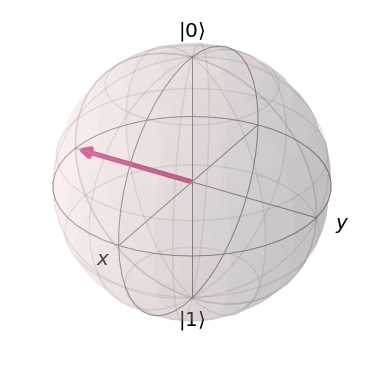

In [8]:
b_sphere=Bloch()
vector = [0, -1, 0]
b_sphere.add_vectors(vector)
b_sphere.show()

Then if, we apply an $Y_{gate}$ our state $\left| -i \right\rangle$ it will stay at the same position. But the entire Bloch sphere will rotate 90-degree around the x-axis. After this rotation the state  $\left| -i \right\rangle$ will be in the computational basis.  

_$\left| -i \right\rangle$ state is going to be mapped into the $\left| 1 \right\rangle$_

In [9]:
def quantum_circuit(parameter, measure):
    # Set up a 2-qubits quantum circuit |00>
    q = QuantumRegister(2)
    c = ClassicalRegister(2)
    circuit = QuantumCircuit(q, c)
    
    # Implementing the ansatz in the circuit
    circuit = ansatz(circuit, parameter)
    
    # Measurements
    circuit.barrier(q[0],q[1])
    if measure == 'XX':
        # H-gate 
        circuit.u2(0, np.pi, q[0])
        circuit.u2(0, np.pi, q[1])
        
    elif measure == 'YY':
        # Y-gate
        circuit.u2(0, np.pi/2, q[0])
        circuit.u2(0, np.pi/2, q[1])
        
    # 'ZZ' measurement dont require additional gates (Y-gate, H-gate)
    circuit.measure(q[0], c[0])
    circuit.measure(q[1], c[1])
    
    return circuit
    

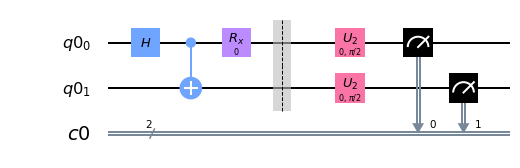

In [10]:
# Let's draw the circuit.
parameter = 0
measure ='YY'
circuit = quantum_circuit(parameter, measure)
circuit.draw('mpl')

### 4th step: Expected values.

Finally, once we are sure that each hamiltonian term will be evaluated on the computational basis we can compute the expected value.

In a 1-qubit system after a measurement we get either  $\left| 0 \right\rangle$ or $\left| 1 \right\rangle $. However in a 2-qubit system there are more possible outcomes: $\left| 00 \right\rangle$, $\left| 01 \right\rangle$, $\left| 10 \right\rangle$ and $\left| 11 \right\rangle$.  

To compute the expected value on this basis we need to repeat the experiment $N$ times and count how many times each output is measured. 

$$\left\langle \psi \right| \sigma_z \otimes \sigma_z \left| \psi \right\rangle = \frac{1}{N}(N_{00}\left\langle 00 \right| \sigma_z \otimes \sigma_z \left| 00 \right\rangle + N_{11}\left\langle 11 \right| \sigma_z \otimes \sigma_z \left| 11 \right\rangle + N_{10}\left\langle 10 \right| \sigma_z \otimes \sigma_z \left| 10 \right\rangle + N_{01}\left\langle 01 \right| \sigma_z \otimes \sigma_z \left| 01 \right\rangle)$$

_Remember other terms like $\left\langle \psi \right| \sigma_x \otimes \sigma_x \left| \psi \right\rangle$ or $\left\langle \psi \right| \sigma_y \otimes \sigma_y \left| \psi \right\rangle$ will be computed in the same way since the physics of the state will not change, we will only rotate our Bloch sphere in order to measure the state in the computational basis._

$$ \left\langle 00 \right| \sigma_z \otimes \sigma_z \left| 00 \right\rangle = \left\langle 11 \right| \sigma_z \otimes \sigma_z \left| 11 \right\rangle = 1 $$

$$ \left\langle 01 \right| \sigma_z \otimes \sigma_z \left| 01 \right\rangle = \left\langle 10 \right| \sigma_z \otimes \sigma_z \left| 10 \right\rangle = -1 $$

So, the expected value can be implemented as

$$\left\langle \psi \right| \sigma_z \otimes \sigma_z \left| \psi \right\rangle = \frac{1}{N}(N_{00}+N_{11}-N_{01}-N_{10}) $$

In [11]:
def measure_expected_value(parameter, measure, num_shots):
    # To measure each term in the right basis.
    if measure == 'II':
        return 1
    else:
        circuit = quantum_circuit(parameter, measure)
        
    # Perform experiment n times to get expected values
    backend = BasicAer.get_backend('qasm_simulator')
    job = execute(circuit, backend, shots=num_shots)
    result = job.result()
    counts = result.get_counts()
    
    N00, N11 = counts.get('00', 0), counts.get('11', 0)
    N01, N10 = counts.get('01', 0), counts.get('10', 0)
    
    expected_value = 1/num_shots*(N00 + N11 - N01 - N10)
    return expected_value

Next step is to get the expected energy of the system after $N$ shots. This step is easy to compute since we just need to sum up all terms. 

$$ \left\langle  H  \right\rangle = \frac{\left\langle \psi \right| II \left| \psi \right\rangle +   \left\langle \psi \right| \sigma_z \sigma_z \left| \psi \right\rangle}{2}     -  \frac{\left\langle \psi \right| \sigma_x \sigma_x \left| \psi \right\rangle  + \left\langle \psi \right| \sigma_y \sigma_y \left| \psi \right\rangle}{2}.$$

The term $\left\langle \psi \right| II \left| \psi \right\rangle$ is trivial because $\left\langle \psi \right| II \left| \psi \right\rangle = \left\langle \psi | \psi \right\rangle = 1$

In [12]:
def energy(parameter, coefficients, num_shots):
    term_II = coefficients['II']*measure_expected_value(parameter, 'II', num_shots)
    term_ZZ = coefficients['ZZ']*measure_expected_value(parameter, 'ZZ', num_shots)
    term_XX = coefficients['XX']*measure_expected_value(parameter, 'XX', num_shots)
    term_YY = coefficients['YY']*measure_expected_value(parameter, 'YY', num_shots)

    return term_II+term_ZZ+term_XX+term_YY


### 5th step: Finding $\theta_{gs}$

**Approach 1: Using an optimizer**

As we said in the beginning VQE is a hybrid quantum-classical algorithm, so far all the steps are computed by a quantum computer. But the last step is to find the parameter $\theta$ with the lowest energy, to tackle this problem will use a classical computer. Following the [qiskit documentation](https://qiskit.org/textbook/ch-applications/vqe-molecules.html#Parameter-Optimization), I will use COBYLA as my optimizer. 

_I also tried SLSQP, but it didn't work as I expected_

In [14]:
# optimization parameters
initial_guess = 1
tolerance = 1e-9 

# quantum system parameters
coefficients = {'II':0.5, 'ZZ':0.5, 'XX':-0.5, 'YY':-0.5}
num_shots = 1000


optimal_theta = minimize(energy,
                         x0=initial_guess,
                         args=(coefficients, num_shots),
                         method='COBYLA',
                         tol=tolerance
                        )
print("Energy ground state = ", optimal_theta.fun)
print("Theta ground state = ", optimal_theta.x, "radians")
print("Theta ground state = ", optimal_theta.x*180/np.pi, "degree")

Energy ground state =  -1.0
Theta ground state =  3.1328125 radians
Theta ground state =  179.49693425582822 degree


**Approach 2: Using a for loop**

Another approach is to simply loop all angles $\theta \in [0, 2\pi)$ and find the state $\left | \psi(\theta) \right\rangle$ with the lowest energy ($E_{gs}$).



In [15]:
angles = np.linspace(0.0, 2.0 * np.pi, 360)
coefficients={'II':0.5, 'ZZ':0.5, 'XX':-0.5, 'YY':-0.5}

energies = list()
for theta in angles:
    E = energy(theta, coefficients, num_shots=1000)
    energies.append(E)

In [16]:
print("Lowest energy: ", min(energies))
theta_gs = angles[np.argmin(np.array(energies))]
print("Theta_ground state = ", theta_gs, "radians")
print("Theta_ground state = ", theta_gs*180/np.pi, "degrees")

Lowest energy:  -1.0
Theta_ground state =  3.097837881255673 radians
Theta_ground state =  177.49303621169912 degrees


Using the second approach it is not a good idea because there are several values of $\theta$ that lead to a $E_{gs}=-1$, so we can't figure out which $\theta$ is the right one.

In [17]:
# Up to 4 values has the ground state value
print("sorted_energies = ", np.sort(np.array(energies))[:10])
print("sorted_angles = ", angles[np.argsort(np.array(energies))][:10]*180/np.pi) 

sorted_energies =  [-1.    -1.    -1.    -1.    -0.999 -0.998 -0.998 -0.998 -0.997 -0.997]
sorted_angles =  [179.49860724 180.50139276 178.49582173 177.49303621 181.50417827
 176.4902507  183.5097493  182.50696379 185.51532033 184.51253482]


## Conclusion

Using VQE algorithm, we end up really close to the correct value of $\theta$. Both approaches are really close to $\theta = 180º$. 

| $\theta_{theoretical}$ | $\theta_{COBYLA}$  | $\theta_{loop}$   |
|------------------------|--------------------|-------------------|
|   180º                 |         179º       |    176º to 181º   |

Although mathematically, there is only one possible state that lead us to the ground state. Using VQE, we see that there are other states that are **really really** close to the ground state.

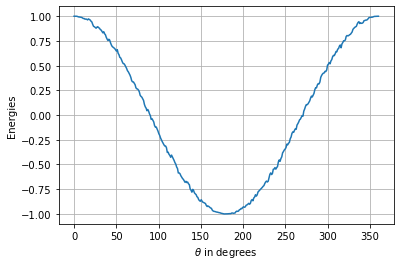

In [18]:
plt.plot(angles*180/np.pi, energies)
plt.xlabel(r"$\theta$ in degrees")
plt.ylabel("Energies")
plt.grid()
plt.show()

### References

1. [Qiskit documentation](https://qiskit.org/textbook/ch-applications/vqe-molecules.html)
2. [Code reference 1](https://github.com/walid-mk/VQE/blob/master/Task4/VQE.Noiseless.Simulator.Code1.ipynb)
3. [Code reference 2](https://github.com/gllodra12/quantum-algorithms-tutorials/blob/master/variational_quantum_eigensolver.ipynb)
4. [Advance code reference](https://nbviewer.jupyter.org/github/alexander-soare/framework-agnostic-vqe-tutorial/blob/master/02_Tutorial.ipynb)
5. [VQE explained](https://www.mustythoughts.com/variational-quantum-eigensolver-explained)

## Bonus

In this section, I will focus on implementing things I would like to get a deeper knowledge about.

I have 3 ideas as bonus exercise:
1. Using a noise simulator
2. Coding a universal ansatz for 4x4 Hamiltonian.
3. Extending the previous code to solve a 8x8 Hamiltonian.

_Idea number 3 it isn't not implemented, I have run out of time, besides I think implementing a universal ansatz will be more challenging than repeting the code from above with a tensor product of 3 Pauli matrices._


### 1. Implementing VQE on a noise simulator.

In this section, we generate a basic device noise model using qiskit package. This model can be further customize using the class QuantumError from qiskit. In addition qiskit class NoiseModel offer further more customization possibilities, we could add a probability error to each qubit using the method: depolarizing_error by the QuantumError class. But for now, we will use a basic noise model.

In [19]:

# Build noise model from backend properties
provider = IBMQ.load_account()
backend = provider.get_backend('ibmq_vigo')
noise_model = NoiseModel.from_backend(backend)

# Get coupling map from backend
coupling_map = backend.configuration().coupling_map

# Get basis gates from noise model
basis_gates = noise_model.basis_gates

In [20]:
def measure_expected_value_with_noise(parameter, measure, num_shots):
    # To measure each term in the right basis.
    if measure == 'II':
        return 1
    else:
        circuit = quantum_circuit(parameter, measure)

    # Perform experiment n times on a noise simulator
    job = execute(circuit, 
                  backend=Aer.get_backend('qasm_simulator'),
                  basis_gates=basis_gates,
                  noise_model=noise_model,
                  coupling_map=coupling_map,
                  shots=num_shots,
                  seed_simulator=0
                 )
    result = job.result()
    counts = result.get_counts()
    
    N00, N11 = counts.get('00', 0), counts.get('11', 0)
    N01, N10 = counts.get('01', 0), counts.get('10', 0)
    
    expected_value = 1/num_shots*(N00 + N11 - N01 - N10)
    return expected_value

In [21]:
def energy_with_noise(parameter, coefficients, num_shots):
    term_II = coefficients['II']*measure_expected_value_with_noise(parameter, 'II', num_shots)
    term_ZZ = coefficients['ZZ']*measure_expected_value_with_noise(parameter, 'ZZ', num_shots)
    term_XX = coefficients['XX']*measure_expected_value_with_noise(parameter, 'XX', num_shots)
    term_YY = coefficients['YY']*measure_expected_value_with_noise(parameter, 'YY', num_shots)

    return term_II+term_ZZ+term_XX+term_YY

In [22]:
# optimization parameters
initial_guess = 0
tolerance = 1e-9 

# quantum system parameters
coefficients = {'II':0.5, 'ZZ':0.5, 'XX':-0.5, 'YY':-0.5}
num_shots = 1000


optimal_theta = minimize(energy_with_noise,
                         x0=initial_guess,
                         args=(coefficients, num_shots),
                         method='COBYLA',
                         tol=tolerance
                        )
print("Energy ground state = ", optimal_theta.fun)
print("Theta ground state = ", optimal_theta.x, "radians")
print("Theta ground state = ", optimal_theta.x*180/np.pi, "degree")

Energy ground state =  -0.8520000000000001
Theta ground state =  3.125 radians
Theta ground state =  179.04931097838227 degree


In [23]:
angles = np.linspace(0.0, 2.0 * np.pi, 360)
coefficients={'II':0.5, 'ZZ':0.5, 'XX':-0.5, 'YY':-0.5}

energies_noise = list()
for theta in angles:
    E = energy_with_noise(theta, coefficients, num_shots=1000)
    energies_noise.append(E)

In [24]:
print("sorted_noise_energies = ", np.sort(np.array(energies_noise))[:10])
print("sorted_noise_angles = ", angles[np.argsort(np.array(energies_noise))][:10]*180/np.pi) 

sorted_noise_energies =  [-0.852 -0.852 -0.851 -0.851 -0.851 -0.851 -0.851 -0.85  -0.85  -0.85 ]
sorted_noise_angles =  [179.49860724 180.50139276 182.50696379 181.50417827 178.49582173
 176.4902507  177.49303621 175.48746518 183.5097493  184.51253482]


### Conclusion:

In this case noise doesn't forbid us to find the true ground state ($\theta=180º$), but since there are error in circuit, the expectation values are not compute correctly. I think that may be the reason why the ground energy in the noise case is greater than when the system is noiseless.

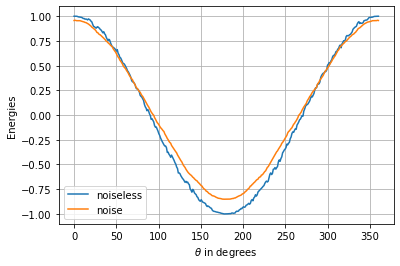

In [26]:
plt.plot(angles*180/np.pi, energies, label='noiseless')
plt.plot(angles*180/np.pi, energies_noise, label='noise')
plt.xlabel(r"$\theta$ in degrees")
plt.ylabel("Energies")
plt.legend()
plt.grid()
plt.show()

## 2. Implementing a  universal parameterized 2-qubit circuit

One thing, I was wondering at the beginning was: Would it be possible to build a general circuit to find the ground state of any 4x4 Hamiltonian? As you might expect, the answer is yes.

My initial idea was to code a circuit from [paper 1](https://arxiv.org/pdf/quant-ph/0307177.pdf) or [paper 2](https://arxiv.org/pdf/quant-ph/0308033.pdf). But, in [paper 1](https://arxiv.org/pdf/quant-ph/0307177.pdf) I didn't understand how to get/code gates $u_1$ and $v_1$ from eq. 3 (I know the explanation is in another paper, but I couldn't understand it weel). On the other hand, [paper 2](https://arxiv.org/pdf/quant-ph/0308033.pdf) it is mathematically heavy and I will need more time to understand it. So, my last option left was to try implementing the circuit in [qiskit documentation](https://qiskit.org/textbook/ch-applications/vqe-molecules.html#Simple-Variational-Forms).

I think, it is better to implement the circuit from [paper 1](https://arxiv.org/pdf/quant-ph/0307177.pdf) or [paper 2](https://arxiv.org/pdf/quant-ph/0308033.pdf), because there are less parameters to optimize, if anyone is willing to share their code, I will be delightful to see a code implementation about any of the two papers. 

In [27]:
def universal_ansatz(circuit, parameters):
    q = circuit.qregs[0]

    # First layer
    circuit.u3(parameters[0], parameters[1], parameters[2], q[0])
    circuit.u3(parameters[3], parameters[4], parameters[5], q[1])
    circuit.cx(q[0], q[1])
    
    # Second layer
    circuit.u3(parameters[6], parameters[7], parameters[8], q[0])
    circuit.u3(parameters[9], parameters[10], parameters[11], q[1])
    circuit.cx(q[1], q[0])
    
    # Third layer
    circuit.u3(parameters[12], parameters[13], parameters[14], q[0])
    circuit.u3(parameters[15], parameters[16], parameters[17], q[1])
    circuit.cx(q[0], q[1])
    
    return circuit

In [28]:
def universal_measurement(measure, circuit, q_regs, c_regs):
    circuit.barrier(q_regs[0],q_regs[1])
    
    # Measure X or Y basis
    for qubit_num, matrix in enumerate(measure):
        if matrix == 'X':
            circuit.u2(0, np.pi, q_regs[qubit_num])

        elif matrix == 'Y':
            circuit.u2(0, np.pi/2, q_regs[qubit_num])

    # Measure Z-basis
    circuit.barrier(q_regs[0],q_regs[1])
    circuit.measure(q_regs[0], c_regs[0])
    circuit.measure(q_regs[1], c_regs[1])
    
    return circuit

In [29]:
def universal_quantum_circuit(parameters, measure):
    # Set up a 2-qubits quantum circuit |00>
    q = QuantumRegister(2)
    c = ClassicalRegister(2)

    circuit = QuantumCircuit(q, c)
    
    # Implementing the ansatz in the circuit
    circuit = universal_ansatz(circuit, parameters)
    
    # Measurments
    circuit = universal_measurement(measure, circuit, q, c)
    
    return circuit
    

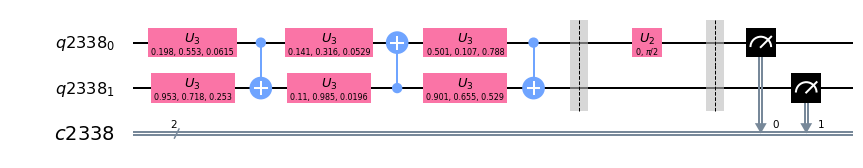

In [30]:
# Draw circuit
measure='YI'
initial_guess = np.random.random(18)
circ = universal_quantum_circuit(parameters=initial_guess, measure=measure)
circ.draw('mpl')

Now, we should be careful because not all the cases will be like: 
$$\left\langle \psi \right| \sigma_z \otimes \sigma_z \left| \psi \right\rangle = \frac{1}{N}(N_{00}+N_{11}-N_{01}-N_{10}) $$  

In case, the Hamiltonian is decomposed in $I\otimes \sigma_x$, the expected value formula would be:
$$\left\langle \psi \right| I \otimes \sigma_x \left| \psi \right\rangle = \frac{1}{N}(N_{00}+N_{10}-N_{01}-N_{11}) $$  

Other cases are also computed in the code below.

In [31]:
def get_expected_value(measure, counts, num_shots):
    matrix_1, matrix_2 = measure
    
    N00, N11 = counts.get('00', 0), counts.get('11', 0)
    N01, N10 = counts.get('01', 0), counts.get('10', 0)
    
    if matrix_1 == 'I':
        return 1/num_shots*(N00 - N11 - N01 + N10)
    elif matrix_2 == 'I':
        return 1/num_shots*(N00 - N11 + N01 - N10)
    else:
        return 1/num_shots*(N00 + N11 - N01 - N10)


def simulating(parameter, measure, num_shots):
    """Compute the expected value of each Hamiltonian term """
    # To measure each term in the right basis.
    if measure == 'II':
        return 1
    else:
        circuit = universal_quantum_circuit(parameter, measure)
    
    # Perform experiment n times to get expected values
    backend = BasicAer.get_backend('qasm_simulator')
    job = execute(circuit, backend, shots=num_shots)
    result = job.result()
    counts = result.get_counts()

    return get_expected_value(measure, counts, num_shots)

In [32]:
def energy(parameter, coefficients, num_shots, exp_value_func):
    """ Sum each expected value term """
    energy = 0
    for pauli_matricies, coef in coefficients.items():
        energy += coef*exp_value_func(parameter, pauli_matricies, num_shots)
        
    return energy

In [33]:
# optimization parameters
initial_guess = np.random.random(18)
tolerance = 1e-9 

# quantum system parameters
coefficients = {'II':0.5, 'ZZ':0.5, 'XX':-0.5, 'YY':-0.5}
num_shots = 1000
func = simulating


optimal_theta = minimize(energy,
                         x0=initial_guess,
                         args=(coefficients, num_shots, func),
                         method='COBYLA',
                         tol=tolerance
                        )
print("Energy ground state = ", optimal_theta.fun)
print("Theta ground state = ", optimal_theta.x, "radians")
print("Theta ground state = ", optimal_theta.x*180/np.pi, "degree")

Energy ground state =  -0.993
Theta ground state =  [ 2.04882919  0.39120461 -0.26738242  2.10687363 -0.42191276  1.84950439
  0.45376952  0.11558373  0.1992564   1.90414094  0.45271702 -0.30181542
  1.25893085  0.44895654  0.1610525   0.59757018  1.62422063  1.4847822 ] radians
Theta ground state =  [117.38926573  22.41437319 -15.31988438 120.71496676 -24.17382023
 105.96879579  25.9990784    6.62245994  11.41655068 109.09923919
  25.9387748  -17.29274954  72.13142441  25.72331506   9.22762879
  34.23824929  93.06098693  85.07175354] degree


**Conclusion:**

As you can see the ground energy is -0.992, but indeed $E_{gs}=-1$, so perhaps there is something wrong with the code. However, I personally believe that because there many parameters to optimize the optimization method is stucked in a local minimum and can't find the global minimum $E_{gs}=-1$. 


_Perhaps, someone with more experience than me will disagree (I will be happy, to get any feedback), but I think it is not worth it to code a general ansatz for this algorithm, there are too many parameters to optimize and I feel the code is overengineered. Even though, it has been a good experience to get a deeper knowledge about vqe_